# Docling + Mistral Graph Extraction (Advanced)

This notebook demonstrates an advanced workflow for extracting structured data from complex documents, like the sample insurance policy.

It uses a powerful two-stage process:
1.  **Docling (`VlmPipeline`)**: Converts the PDF into high-quality, layout-aware Markdown. This step understands the document's structure, tables, and reading order.
2.  **Mistral API (`mistral-large-latest`)**: A powerful general-purpose LLM reads the structured Markdown and the Pydantic schema to extract the complex data into a clean JSON object.
3.  **GraphConverter**: The resulting JSON is validated and converted into a NetworkX knowledge graph, just like in the previous notebook.

In [ ]:
%pip install -q docling pymupdf mistralai networkx matplotlib plotly pygraphviz rich

In [3]:
import os
import sys
import json
import textwrap
import fitz  # PyMuPDF
from importlib import import_module

from rich import print
from IPython.display import Image, HTML, display
from pydantic import BaseModel, Field
from typing import Optional, List, Any

# Mistral API Client
from mistralai import Mistral

# Docling Imports for PDF-to-Markdown
from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline

# Your existing scripts
sys.path.append('.')
try:
    from scripts.graph_converter import GraphConverter
    from scripts.graph_visualizer import create_static_graph, create_interactive_graph
except ImportError:
    print("[bold red]Warning: Could not find scripts/graph_converter.py or scripts/graph_visualizer.py.[/bold red]")
    print("Please ensure they are in a 'scripts' folder in the same directory as this notebook.")

## 1. Define Input Document and Pydantic Schema

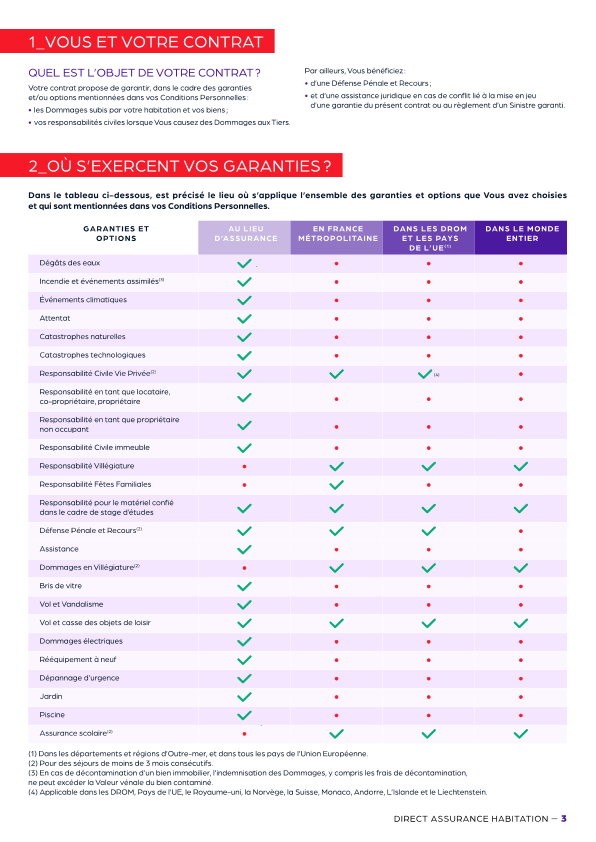

In [20]:
# We'll use the complex insurance document as our source
file_path = "data/assurance_options_multipage.pdf"
template_module = "insurance"
template_class = "HomeInsurance"

# Display the first page of the PDF for reference
if os.path.exists(file_path):
    doc = fitz.open(file_path)
    page = doc.load_page(1)
    pix = page.get_pixmap()
    output_image = "data/page_preview.png"
    pix.save(output_image)
    display(Image(filename=output_image))
else:
    print(f"[bold red]Error: Input file not found at {file_path}[/bold red]")

In [5]:
# Load the Pydantic Template from the templates/ folder
print(f"[bold green]Loading template: {template_module}.{template_class}[/bold green]")
try:
    TemplateModule = import_module(f"templates.{template_module}")
    Template = getattr(TemplateModule, template_class)
    print("Template loaded successfully.")
except ImportError:
    print(f"[bold red]Error: Could not import {template_class} from templates/{template_module}.py[/bold red]")
    Template = None

Loading template: insurance.HomeInsurance

Template loaded successfully.

## 2. Step 1: Convert Document to Markdown

Using `docling.DocumentConverter` with `VlmPipeline` to get layout-aware Markdown. This uses the default `granite-docling` model to understand the document structure.

In [ ]:
# This is the setup from your code snippet
converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_cls=VlmPipeline,
        ),
    })

source = file_path
markdown_content = None

if os.path.exists(source) and Template:
    print(f"Converting '{source}' to Markdown using Docling VlmPipeline...")
    doc = converter.convert(source=source).document
    markdown_content = doc.export_to_markdown()
    print(f"[bold green]Document converted. Markdown length: {len(markdown_content)}[/bold green]")
else:
    print(f"[bold red]Error: File not found at {source} or Template not loaded. Skipping conversion.[/bold red]")

Converting 'data/assurance_options_multipage.pdf' to Markdown using Docling VlmPipeline...

2025-10-22 17:17:23,234 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-10-22 17:17:23,235 - INFO - Going to convert document batch...
2025-10-22 17:17:23,235 - INFO - Initializing pipeline for VlmPipeline with options hash 14b35a24912cc09d5c7735b8ff9d88c1
2025-10-22 17:17:23,237 - INFO - Accelerator device: 'cpu'
2025-10-22 17:17:23,886 - INFO - Processing document assurance_options_multipage.pdf
2025-10-22 17:17:46,999 - INFO - Finished converting document assurance_options_multipage.pdf in 23.77 sec.


Document converted. Markdown length: 966

### Review Markdown Content (Optional)

In [ ]:
if markdown_content:
    print("--- Start of Markdown Snippet ---")
    print(markdown_content[:1000])  # Print first 1000 characters for brevity
    print("--- End of Markdown Snippet ---")

--- Start of Markdown Snippet ---

## 1\_VOUSETVOTRECONTRAT

## QUEL EST L'OBJET DE VOTRE

Votre contrat propose de garantir, dans le cadre des garanties et/ou options mentionnées dans vos Conditions 
Personnelles.

- · les Dommages subis par votre habitation et votre biens;
- · vos responsabilités civiles lorsque Vous causez des Dommages aux Tiers.

## 2\_Où S'EXERCITENT VOS GARANTIES ?

Dans le tableau ci-dessous, est pricé le lieu où s'applique l'ensemble des garanties et options que Vous avez 
choisies et qui sont mentionnées dans vos Comditons Personnelles.

Assurance scolaire (2)

- (1) Dans les départements et régions d'Outre-met, et dans tous les pays de l'Union Européenne.
- (2) Pour des séjours de moins de 3 mois consécutifs.
- (3) En cas de décontamination d'un bien immobile, l'indemnisation des Dommages, y compris les frais 
d'établissement et le Liechtenstein.
- (4) Applicable dans les DROM, Pays de l'UE, le Royaume-uni, la Norvège, la Suisse, Monaco, Andorre, 
L'Isle-de-l'Ile.

--- End of Markdown Snippet ---

## 3. Step 2: Extract JSON using Mistral API

Now we create a prompt combining the schema and the Markdown, then query the Mistral API using JSON mode.

In [8]:
json_output = None
prompt_text = None

if markdown_content and Template:
    print("Generating Pydantic schema as JSON...")
    schema_json = json.dumps(Template.model_json_schema(), indent=2)
    
    prompt_text = f"""You are an expert information extraction system. Your task is to extract structured data from the provided document text and format it as a valid JSON object that strictly adheres to the given Pydantic JSON schema.
The document is an insurance policy comparison table.
You must extract details for *all* guarantees and *all* plans listed. Pay close attention to nested objects like 'reimbursement_conditions' and ensure all relevant fields are populated from the text.

--- DOCUMENT MARKDOWN ---
{markdown_content}

--- PYDANTIC JSON SCHEMA ---
{schema_json}

---
Based *only* on the document text, return a valid JSON object matching the schema. Do not include any other text, explanations, or markdown formatting (like ```json) in your response.
"""
    print(f"Prompt created. Total length: {len(prompt_text)} characters.")
else:
    print("[bold yellow]Markdown content or Template not available. Skipping prompt generation.[/bold yellow]")

Generating Pydantic schema as JSON...

Prompt created. Total length: 12144 characters.

In [11]:
api_key = os.getenv("MISTRAL_API_KEY", "")
if not api_key:
    print("[bold red]Error: MISTRAL_API_KEY environment variable not set.[/bold red]")
    print("Please set the key and restart the kernel to run the extraction.")
else:
    print("MISTRAL_API_KEY initialized.")

MISTRAL_API_KEY initialized.

In [13]:
if api_key and prompt_text:
    print("Querying Mistral API (mistral-large-latest) with JSON mode... This may take a moment.")
    try:
        with Mistral(api_key=api_key) as mistral:
            res = mistral.chat.complete(
                model="mistral-small-latest",
                messages=[
                    {
                        "role": "user",
                        "content": prompt_text,
                    }
                ],
                response_format={"type": "json_object"},
                stream=False,
            )

        raw_json_output = res.choices[0].message.content
        print("[bold green]Successfully received response from Mistral API.[/bold green]")
        print("--- Raw JSON Output ---")
        print(raw_json_output)
        print("-----------------------")

        # Parse JSON
        json_output = json.loads(raw_json_output)

    except json.JSONDecodeError as e:
        print(f"[bold red]Failed to parse JSON from Mistral: {e}[/bold red]")
        print("--- Raw Output That Failed Parsing ---")
        print(raw_json_output)
    except Exception as e:
        print(f"[bold red]Error during Mistral API call: {e}[/bold red]")
else:
    print("[bold yellow]Mistral client not initialized or prompt not generated. Skipping extraction.[/bold yellow]")


Querying Mistral API (mistral-large-latest) with JSON mode... This may take a moment.

2025-10-22 17:13:05,620 - INFO - HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


Successfully received response from Mistral API.

--- Raw JSON Output ---

{
  "product_name": "Assurance Habitation",
  "all_guarantees": [
    {
      "name": "Dégâts des eaux",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Incendie et événements assimilés",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Événements climatiques",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Attentat",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Catastrophes naturelles et technologiques",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Responsabilité civile",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Défense Pénale et Recours",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Assistance",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Bris de vitre",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Vol et vandalisme",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Vol et casse des objets de loisir",
      "description": null,
      "covered_items": null,
      "covered_scenarios": null,
      "reimbursement_conditions": null
    },
    {
      "name": "Dommages électriques",
      "description": "La surtension ou la foudre endommage votre électroménager? Cette garantie ne vous laissera 
pas sans équivalent. Les Dommages causés par une explosion ou de l'implosion ou lors d'une surtension sont 
indemnisés.",
      "covered_items": [
        "électroménager"
      ],
      "covered_scenarios": [
        "surtension",
        "foudre",
        "explosion",
        "implosion"
      ],
      "reimbursement_conditions": null
    },
    {
      "name": "Rééquipement à neuf",
      "description": "Grâce à l'option Rééquipement à neuf, vos appareils de l'électroménager et informatiques de 
moins de 5 ans sont indemnisés. À la valeur actuelle du bien au moins du Sinistre. En plus, vos meubles de moins de
2 ans sont également remboursés à la valeur du bien au moins du Sinistre. Au moment du Sinistre, les appareils sont
dépendant du bien du jeu du sens.",
      "covered_items": [
        "appareils électroménagers et informatiques",
        "meubles"
      ],
      "covered_scenarios": null,
      "reimbursement_conditions": [
        {
          "item_category": "appareils électroménagers et informatiques",
          "age_limit_years": 5,
          "reimbursement_basis": "valeur actuelle du bien"
        },
        {
          "item_category": "meubles",
          "age_limit_years": 2,
          "reimbursement_basis": "valeur du bien"
        }
      ]
    },
    {
      "name": "Dépandage d'urgence",
      "description": "Porte clauée, apparition de fuites ou pneumatique? Grâce à cette intervention, d'un 
protection de prévention de la défense d'électroménager. Cette garantie prend en charge le diagnostic et la 
réparation de problèmes de serrurier, d'électricité et de plombérieure.",
      "covered_items": null,
      "covered_scenarios": [
        "Porte claquée",
        "fuites",
        "panne électrique"
      ],
      "reimbursement_conditions":

-----------------------

## 4. Step 3: Validate and Convert to Graph

In [14]:
template_object = None
if json_output:
    print("Validating extracted JSON data against Pydantic schema...")
    try:
        template_object = Template.model_validate(json_output)
        print("[bold green]Data successfully validated![/bold green]")
        print(template_object)
    except Exception as e:
        print(f"[bold red]Pydantic validation failed: {e}[/bold red]")
else:
    print("[bold yellow]No valid JSON to process. Skipping graph conversion.[/bold yellow]")

Validating extracted JSON data against Pydantic schema...

Data successfully validated!

HomeInsurance(
    product_name='Assurance Habitation',
    all_guarantees=[
        Guarantee(
            name='Dégâts des eaux',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Incendie et événements assimilés',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Événements climatiques',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Attentat',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Catastrophes naturelles et technologiques',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Responsabilité civile',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Défense Pénale et Recours',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Assistance',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Bris de vitre',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Vol et vandalisme',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Vol et casse des objets de loisir',
            description=None,
            covered_items=None,
            covered_scenarios=None,
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Dommages électriques',
            description="La surtension ou la foudre endommage votre électroménager? Cette garantie ne vous laissera
pas sans équivalent. Les Dommages causés par une explosion ou de l'implosion ou lors d'une surtension sont 
indemnisés.",
            covered_items=['électroménager'],
            covered_scenarios=['surtension', 'foudre', 'explosion', 'implosion'],
            reimbursement_conditions=None
        ),
        Guarantee(
            name='Rééquipement à neuf',
            description="Grâce à l'option Rééquipement à neuf, vos appareils de l'électroménager et informatiques 
de moins de 5 ans sont indemnisés. À la valeur actuelle du bien au moins du Sinistre. En plus, vos meubles de moins
de 2 ans sont également remboursés à la valeur du bien au moins du Sinistre. Au moment du Sinistre, les appareils 
sont dépendant du bien du jeu du sens.",
            covered_items=['appareils électroménagers et informatiques', 'meubles'],
            covered_scenarios=None,
            reimbursement_conditions=[
                ReimbursementCondition(
                    item_category='appareils électroménagers et informatiques',
                    age_limit_years=5,
                    reimbursement_basis='valeur actuelle du bien'
                ),
                ReimbursementCondition(
                    item_category='meubles',
                    age_limit_years=2,
                    reimbursement_basis='valeur du bien'
                )
            ]
        ),
        Guarantee(
            n

In [18]:
knowledge_graph = None
if template_object:
    print("Converting Pydantic object to NetworkX graph...")
    converter = GraphConverter()
    knowledge_graph = converter.pydantic_to_graph(template_object)

    print(
        "Graph conversion complete:\n"
        f"- Nodes: {knowledge_graph.number_of_nodes()}\n"
        f"- Edges: {knowledge_graph.number_of_edges()}"
    )
    print("[bold green]Knowledge graph created successfully.[/bold green]")

Converting Pydantic object to NetworkX graph...

Graph conversion complete:
- Nodes: 21
- Edges: 20

Knowledge graph created successfully.

## 5. Step 4: Visualize the Knowledge Graph

### 5.1. Display the Graph's Nodes and Edges

In [23]:
if knowledge_graph:
    output = ["\n[bold green]--- Graph Elements Start ---[/bold green]\n"]

    output.append("NODES (with properties):")
    for node, data in knowledge_graph.nodes(data=True):
        output.append(f"  [{node}]")
        for key, value in data.items():
            output.append(f"    • {key}: {value}")
        output.append("")  # blank line between nodes

    output.append("EDGES (with labels):")
    for u, v, data in knowledge_graph.edges(data=True):
        label = data.get('label', '')
        output.append(f"  {u.split('_')[0]} → {v.split('_')[0]}   [{label}]")

    output.append("\n[bold green]--- Graph Elements End ---[/bold green]\n")

    print("\n".join(output))
else:
    print("No graph to display.")

--- Graph Elements Start ---

NODES (with properties):
  [HomeInsurance_1411a7f66096]
    • label: HomeInsurance
    • product_name: Assurance Habitation

  [Guarantee_c21e770c17bd]
    • label: Guarantee
    • name: Dégâts des eaux
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_9a15e8f8d8fa]
    • label: Guarantee
    • name: Incendie et événements assimilés
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_04b30e448ff5]
    • label: Guarantee
    • name: Événements climatiques
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_e0c60f7bd258]
    • label: Guarantee
    • name: Attentat
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_6d9f029695a9]
    • label: Guarantee
    • name: Catastrophes naturelles et technologiques
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_5b63dfdb8dbc]
    • label: Guarantee
    • name: Responsabilité civile
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_34389af8a538]
    • label: Guarantee
    • name: Défense Pénale et Recours
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_e35dbd8d7aa0]
    • label: Guarantee
    • name: Assistance
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_bb3ad2e9845a]
    • label: Guarantee
    • name: Bris de vitre
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_6d3610a2598e]
    • label: Guarantee
    • name: Vol et vandalisme
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_c7d7ad099bf4]
    • label: Guarantee
    • name: Vol et casse des objets de loisir
    • description: None
    • covered_items: None
    • covered_scenarios: None
    • reimbursement_conditions: None

  [Guarantee_ab5d77e1b076]
    • label: Guarantee
    • name: Dommages électriques
    • description: La surtension ou la foudre endommage votre électroménager? Cette garantie ne vous laissera pas 
sans équivalent. Les Dommages causés par une explosion ou de l'implosion ou lors d'une surtension sont indemnisés.
    • covered_items: ['électroménager']
    • covered_scenarios: ['surtension', 'foudre', 'explosion', 'implosion']
    • reimbursement_conditions: None

  [Guarantee_979038fac2a2]
    • label: Guarantee
    • name: Rééquipement à neuf
    • description: Grâce à l'option Rééquipement à neuf, vos appareils de l'électroménager et informatiques de 
moins de 5 ans sont indemnisés. À la valeur actuelle du bien au moins du Sinistre. En plus, vos meubles de moins de
2 ans sont également remboursés à la valeur du bien au moins du Sinistre. Au moment du Sinistre, les appareils sont
dépendant du bien du jeu du sens.
    • covered_items: ['appareils électroménagers', 'appareils informatiques', 'meubles']
    • covered_scenarios: None
    • reimbursement_conditions: [{'item_category': 'appareils électroménagers et informatiques', 'age_limit_years':
5, 'reimbursement_basis': 'valeur actuelle du bien'}, {'item_category': 'meubles', 'age_limit_years': 2, 
'reimbursement_basis': 'valeur actuelle du bien'}]

  [Guarantee_66c830725339]
    • label: Guarantee
    • name: Dépannage d'urgence
    • description: Porte claquée, apparition de fuites ou pneumatique? Grâce à cette intervention, d'un protection 
de prévention de la défense d'électroménager. Cette garantie prend en charge le diagnostic et la ré

### 5.2. Draw and Save the Graph as an Image

Using 'graphviz' for a hierarchical layout.


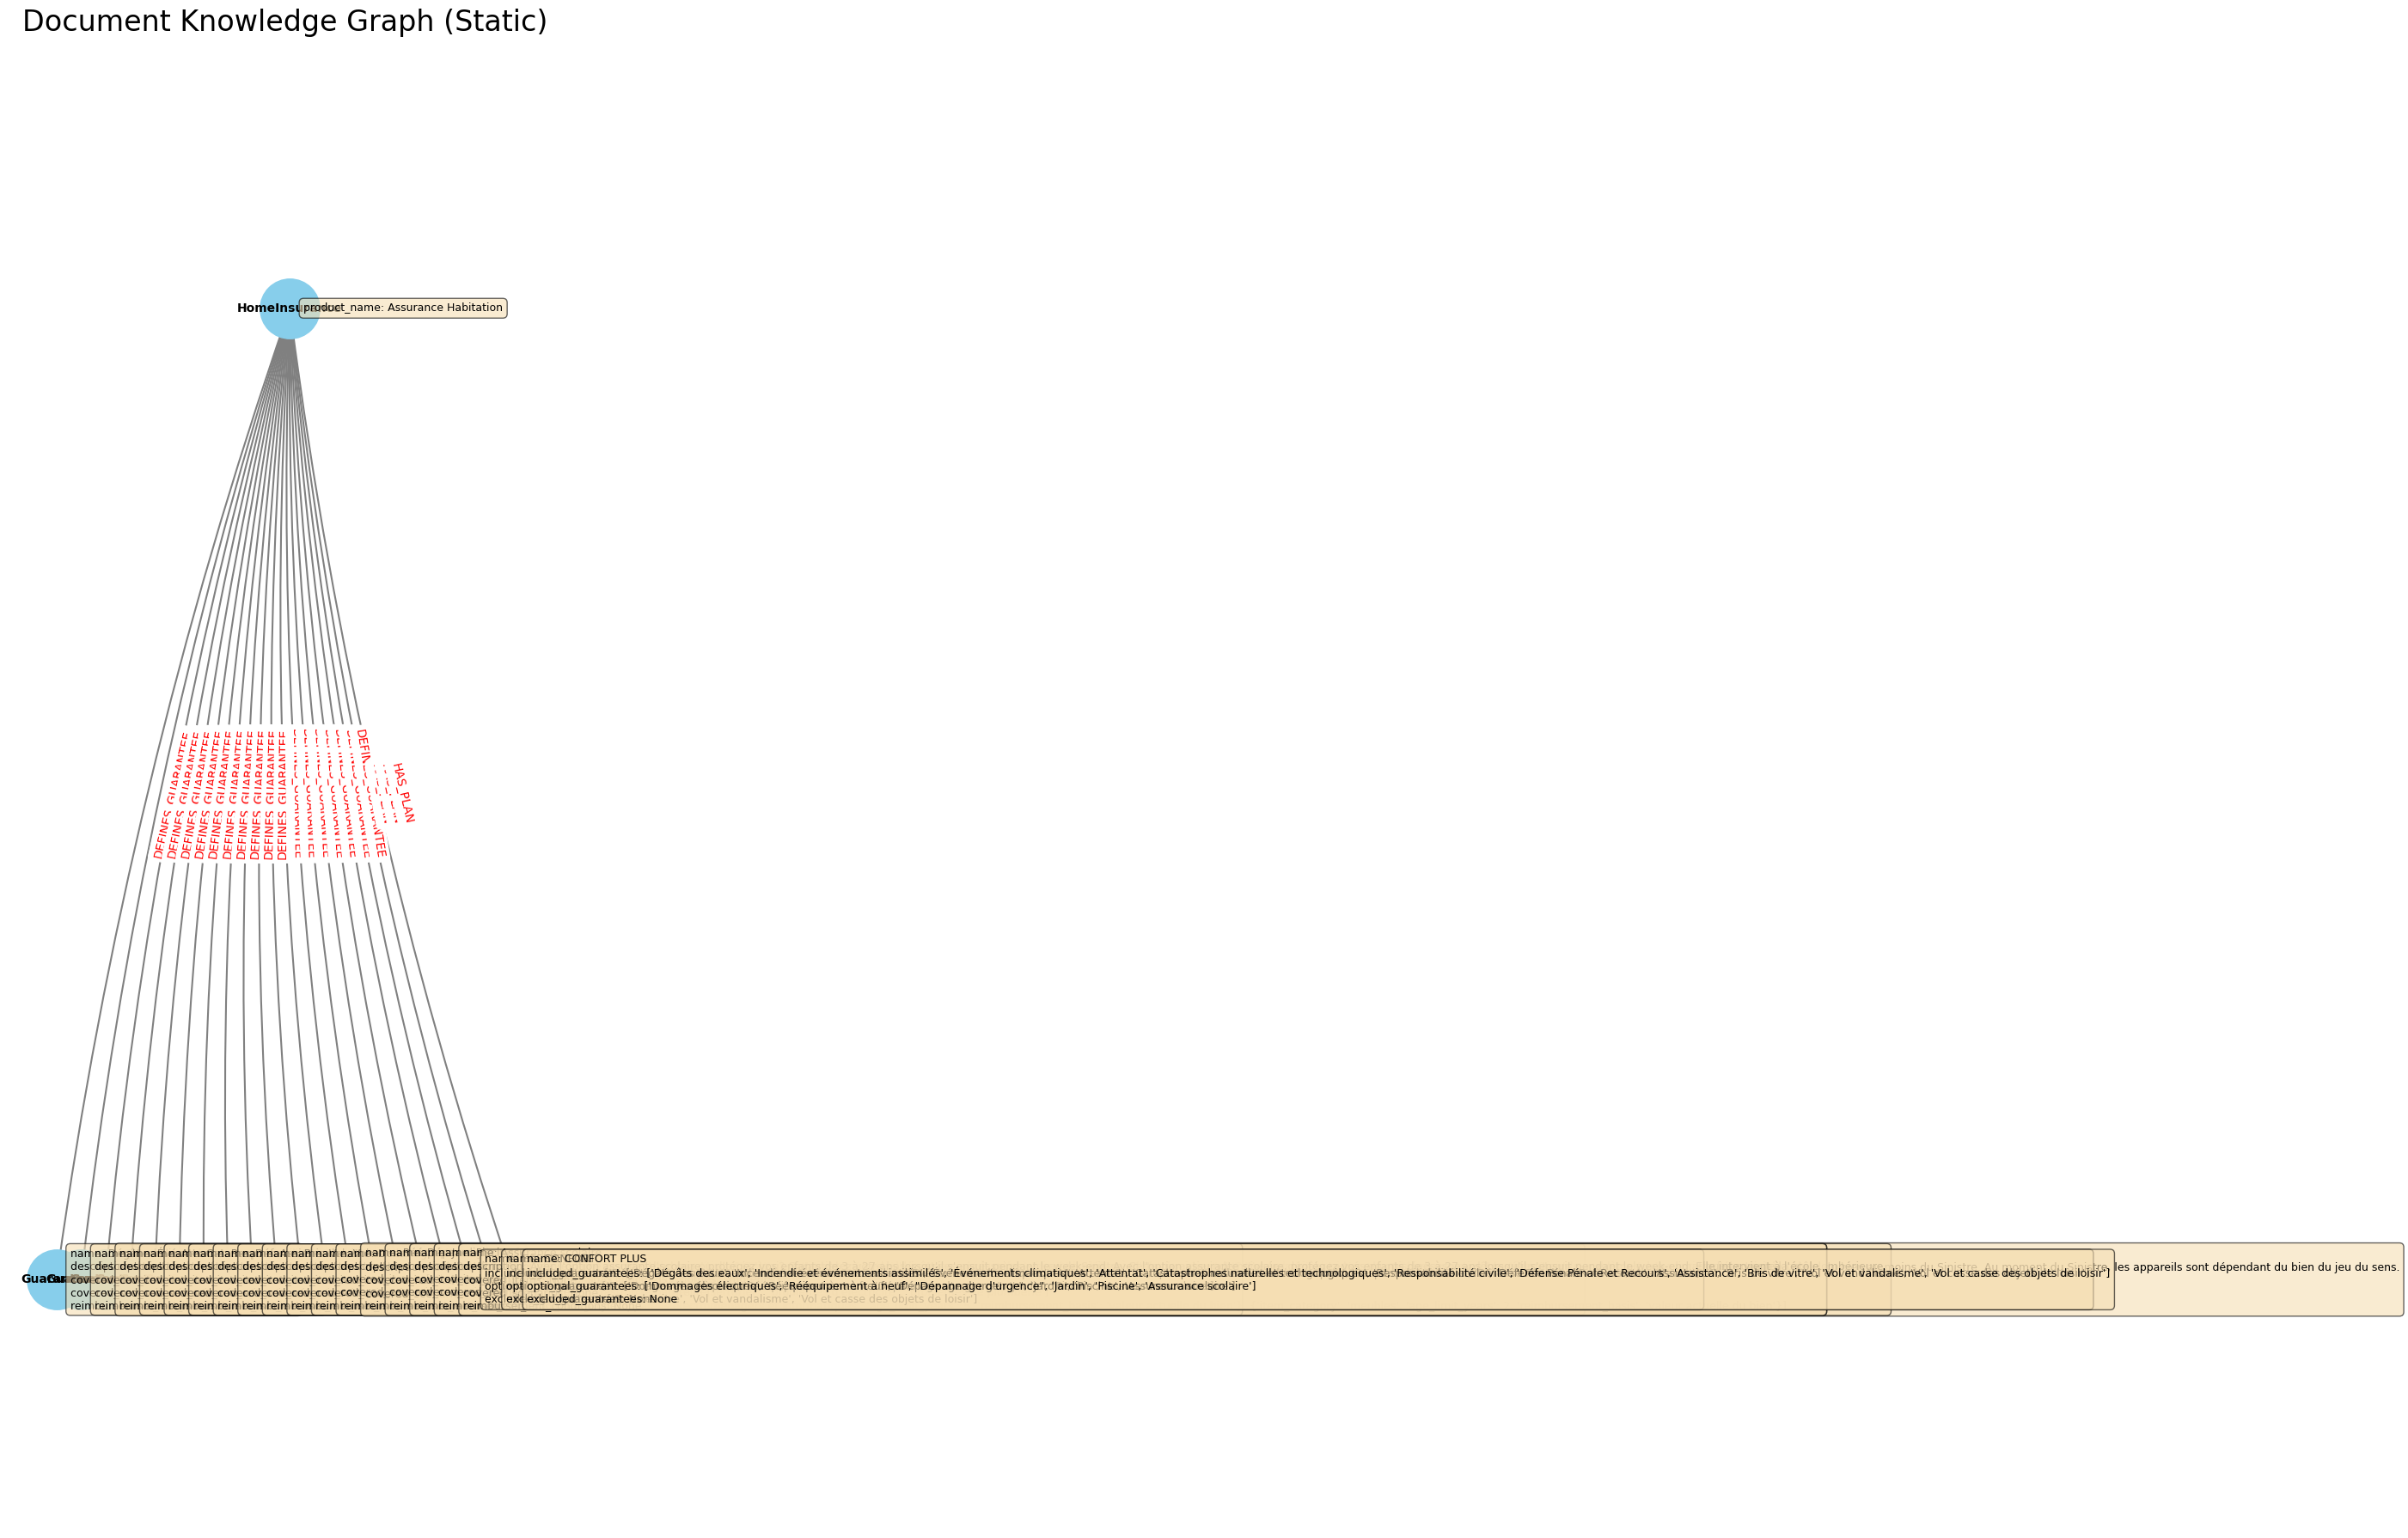

Static graph with properties saved to outputs\static_graph.png


Graph image created successfully.

In [26]:
if knowledge_graph:
    # Draw the graph and save it to a file
    static_image_file = "static_graph.png"
    create_static_graph(knowledge_graph, filename=static_image_file)
    print("[bold green]Graph image created successfully.[/bold green]")
else:
    print("No graph to visualize.")

### 5.3. Generate Interactive Visualization with Plotly

In [27]:
if knowledge_graph:
    # Create an Interactive Visualization with PyVis
    interactive_html_file = "interactive_graph.html"
    html_path = create_interactive_graph(knowledge_graph, filename=interactive_html_file)
    print("[bold green]Interactive graph created successfully.[/bold green]")
else:
    print("No graph to visualize.")

Interactive Plotly graph saved to: outputs\interactive_graph.html


Interactive graph created successfully.